# Trained Model Evaluation Notebook


In [1]:
import tqdm.notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
from IPython.display import HTML

from plnn.models import DeepPhiPLNN
from plnn.dataset import get_dataloaders
from plnn.data_generation.plnn_animator import PLNNSimulationAnimator
from plnn.io import load_model_from_directory, load_model_training_metadata
from plnn.loss_functions import kl_divergence_loss

SEED = None
rng = np.random.default_rng(seed=SEED)


### Model Loading

In [2]:
BASEDIR = "../data/trained_models"
MODEL_DIR = "model_phi1_1a_v1_20240311_130654"
MODEL_NAME = "model_phi1_1a_v1"

DATDIR = "../data/training_data/data_phi1_1a"

INDEX = 'best'
modeldir = f"../data/trained_models/{MODEL_DIR}"

In [3]:
datdir_train = f"{DATDIR}/training"
datdir_valid = f"{DATDIR}/validation"
datdir_test = f"{DATDIR}/testing"

nsims_train = np.genfromtxt(f"{datdir_train}/nsims.txt", dtype=int)
nsims_valid = np.genfromtxt(f"{datdir_valid}/nsims.txt", dtype=int)
nsims_test = np.genfromtxt(f"{datdir_test}/nsims.txt", dtype=int)

In [4]:
# Load the model
model, hyperparams, idx, model_name, model_fpath = load_model_from_directory(
    modeldir, 
    subdir="states",
    idx=INDEX,
    model_class=DeepPhiPLNN,
    dtype=jnp.float64,
)

# Load the argument dictionary and training run dictionary
logged_args, run_dict = load_model_training_metadata(
    modeldir
)

loss_train = run_dict['loss_hist_train']
loss_valid = run_dict['loss_hist_valid']
sigma_hist = run_dict['sigma_hist']
lr_hist = run_dict['learning_rate_hist']

print(f"Loading model `{model_name}` at epoch {idx} from file: {model_fpath}.")

Loading model `model_phi1_1a_v1` at epoch 1858 from file: ../data/trained_models/model_phi1_1a_v1_20240311_130654/states/model_phi1_1a_v1_1858.pth.


### Training process metadata
Before examining the inferred landscape, let's look at the training process metadata.

In [5]:
from plnn.pl import plot_training_loss_history, plot_validation_loss_history, \
    plot_loss_history, plot_sigma_history, plot_learning_rate_history

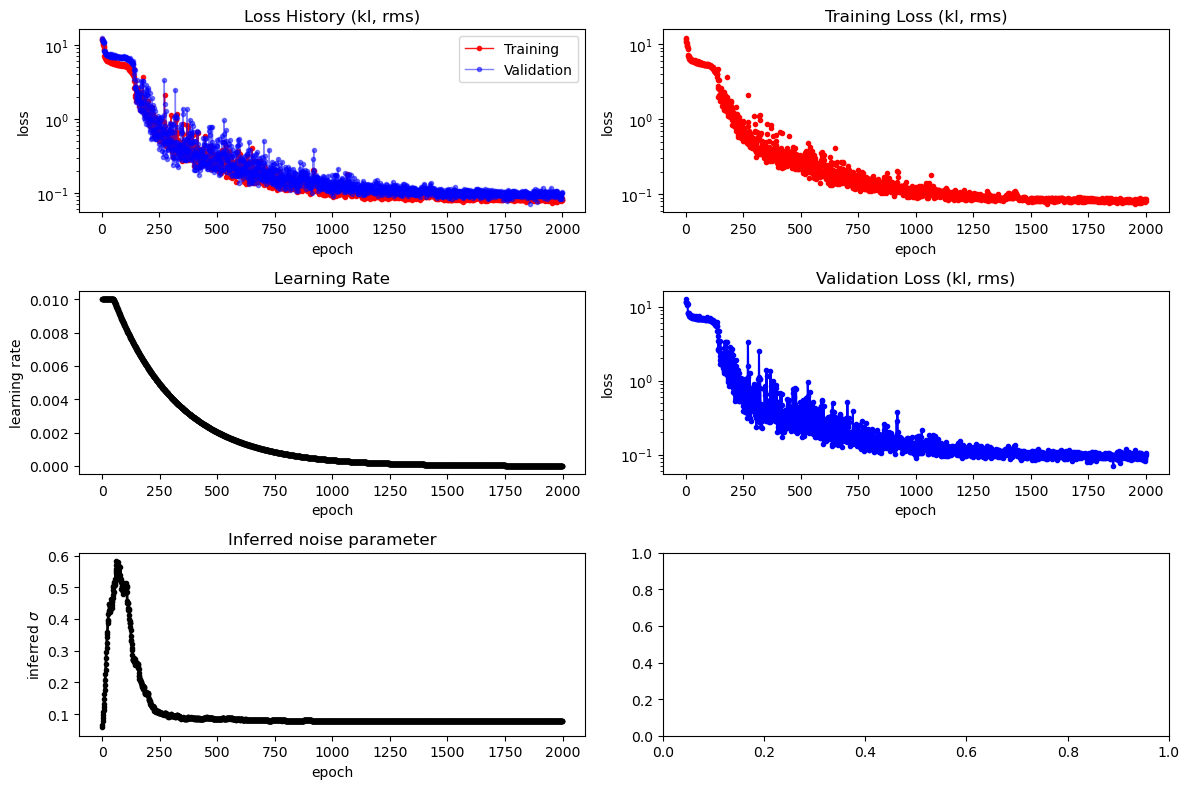

In [6]:
logplot = True
loss_method = logged_args['loss']
optimizer = logged_args['optimizer']

fig, axes = plt.subplots(3, 2, figsize=(12,8))

plot_loss_history(
    loss_train, loss_valid,
    log=logplot, 
    title=f"Loss History ({loss_method}, {optimizer})",
    ax=axes[0, 0],
)

plot_learning_rate_history(
    lr_hist, log=False,
    ax=axes[1, 0],
)

plot_sigma_history(
    sigma_hist, log=False,
    ax=axes[2, 0],
)

plot_training_loss_history(
    loss_train, 
    log=logplot, 
    title=f"Training Loss ({loss_method}, {optimizer})",
    ax=axes[0, 1],
    color='r', marker='.', linestyle='none',
)

plot_validation_loss_history(
    loss_valid, 
    log=logplot, 
    title=f"Validation Loss ({loss_method}, {optimizer})",
    ax=axes[1, 1],
    color='b',
)

plt.tight_layout()

### Variance in loss
Let's examine the noisyness of the training and validation loss in the plots above.



In [7]:
key = jrandom.PRNGKey(rng.integers(2**32))

In [8]:
k = 100
var_train_loss = np.var(loss_train[-k:])
var_valid_loss = np.var(loss_valid[-k:])
print(f"Training loss variance (last {k} epochs)  : {var_train_loss}")
print(f"Validation loss variance (last {k} epochs): {var_valid_loss}")


Training loss variance (last 100 epochs)  : 5.432196874158245e-06
Validation loss variance (last 100 epochs): 4.067465489428361e-05


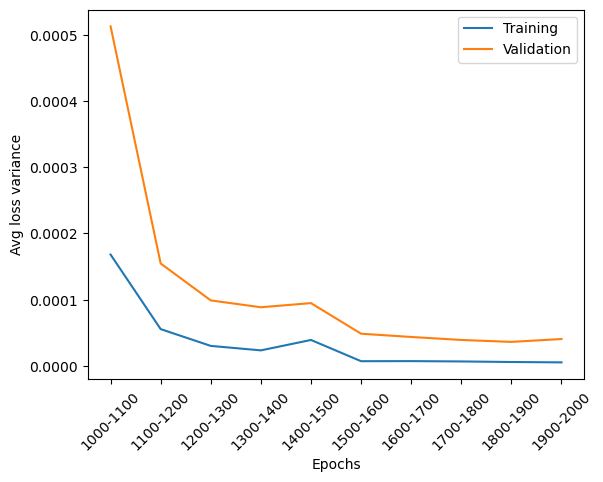

In [9]:
nepochs = len(loss_train)
start_epoch = 1000
k = 100
vtls = []
vvls = []
ranges = []
for i in range((nepochs - start_epoch) // k):
    n0, n1 = start_epoch + k*i, start_epoch + k*(i+1)
    tset = loss_train[n0:n1]
    vset = loss_valid[n0:n1]
    var_train_loss = np.var(tset)
    var_valid_loss = np.var(vset)
    vtls.append(var_train_loss)
    vvls.append(var_valid_loss)
    ranges.append(str(n0) + '-' + str(n1))

fig, ax = plt.subplots(1, 1)
ax.plot(vtls, label="Training")
ax.plot(vvls, label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Avg loss variance")
ax.legend()
ax.set_xticks(range(len(ranges)), ranges, rotation=45);

In [10]:
_, _, test_loader, _, _, test_dset = get_dataloaders(
    datdir_train, datdir_valid, nsims_train, nsims_valid,
    return_datasets=True,
    include_test_data=True,
    datdir_test=datdir_test, nsims_test=nsims_test, shuffle_test=True,
    batch_size_test=20
)

In [11]:
@eqx.filter_jit
def compute_loss(model, x, y, loss_fn, key):
    t0, y0, t1, sigparams = x
    y_pred = model(t0, t1, y0, sigparams, key)
    return loss_fn(y_pred, y), y_pred

In [12]:
ntrials = 10

avg_test_losses = np.zeros(ntrials)
pbar = tqdm.tqdm(total=len(test_loader))
for i in range(ntrials):
    test_losses = np.zeros(len(test_loader))
    pbar.set_description(f"i={i}/{ntrials}")
    for j, d in enumerate(test_loader):
        x, y = d
        key, subkey = jrandom.split(key, 2)
        loss, _ = compute_loss(model, x, y, kl_divergence_loss, subkey)
        test_losses[j] = loss
        pbar.update()
    avg_test_losses[i] = np.sum(test_losses) / len(test_loader)
    pbar.refresh()
    pbar.reset()
pbar.close()

print(np.var(avg_test_losses))

  0%|          | 0/15 [00:00<?, ?it/s]

1.0499161419325744e-05


## Comparison of true and inferred ensemble trajectories


In [13]:
_, _, test_loader, _, _, test_dset = get_dataloaders(
    datdir_train, datdir_valid, nsims_train, nsims_valid,
    return_datasets=True,
    include_test_data=True,
    datdir_test=datdir_test, nsims_test=nsims_test, shuffle_test=True,
    batch_size_test=1
)

In [14]:
key = jrandom.PRNGKey(123)

nsamps = 4
test_indices = [10, 78, 123, 132]

losses = np.zeros(nsamps)
x1obs_samples = []
x1sim_samples = []
iterloader = iter(test_loader)
for i in range(nsamps):
    inputs, x1obs = next(iterloader)
    inputs, x1obs = test_dset[test_indices[i]]
    t0, x0, t1, sigparams = inputs
    inputs = (jnp.array([v], dtype=jnp.float64) for v in inputs)
    x1obs = jnp.array([x1obs])
    key, subkey = jrandom.split(key, 2)
    model
    loss, x1sim = compute_loss(model, inputs, x1obs, kl_divergence_loss, subkey)
    losses[i] = loss
    x1obs_samples.append(x1obs[0])
    x1sim_samples.append(x1sim[0])

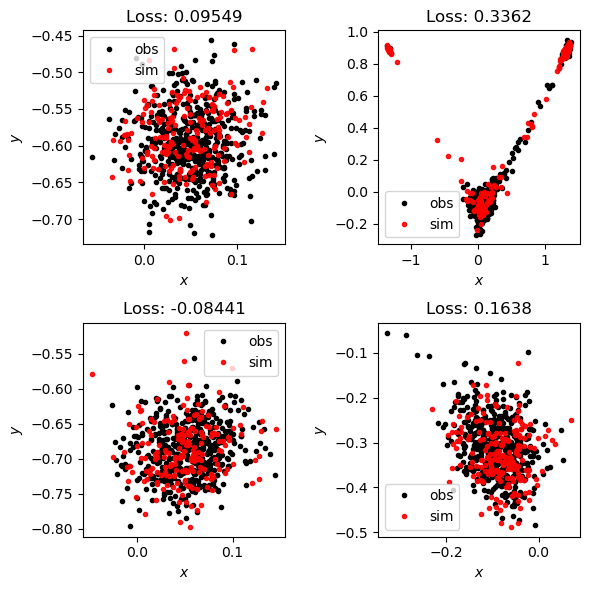

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(6,6))

for i in range(len(losses)):
    ax = axes.flatten()[i]
    ax.plot(
        x1obs_samples[i][:,0], x1obs_samples[i][:,1], 
        color='k', marker='.', linestyle='none',
        label="obs"
    )
    ax.plot(
        x1sim_samples[i][:,0], x1sim_samples[i][:,1], 
        color='r', marker='.', linestyle='none',
        label="sim",
        alpha=0.9
    )
    ax.legend()
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_title(f"Loss: {losses[i]:.4g}")

plt.tight_layout()